As part of our overarching strategy for assigning users to specific sectors, we need to be able to assign users to business as well.  Given the specifics of our source dataset (GHTorrent), we can reasonably assume that the more frequently that a company name appears, the more "authoratative" (reflective of a consensus) of a representation of that company name it is.  Once we've removed the user entries that correspond to the non-business sectors, we can be reasonably confident in mapping users whose worplace affiliation listing is shared with some critical threshold of other users (i.e. 5) to the business sector.

Lets begin by [obtaining the raw user data from the sql database](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/3a4431544bc32ac6abc82f14f8ccdd9f90923089/ossPy/ossPyFuncs.py#L9), as well as the user mappings for the acadmic and government sector.

In [1]:
import os
os.chdir('../')
#assuming you're starting this notebook from it's source directory,
#this will get us to the directory containing the ossPyFuncs library
import ossPyFuncs

#obtain the raw GHTorrent data
postgreSql_selectQuery="SELECT login, company FROM gh.ctrs_raw ;"
fullData=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)

#perform sql query for academic entries
postgreSql_selectQuery="SELECT login, company_cleaned, is_academic FROM gh.sna_ctr_academic ;"
academicCleaned=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)

#perform sql qery for government entries
postgreSql_selectQuery="SELECT login, is_gov FROM gh.sna_ctr_gov ;"
govData=ossPyFuncs.queryToPDTable(postgreSql_selectQuery)


#add nonprofit here and in the next code block if desired

Now that we have obtained those pre-exisitng user mappings, we need to join them into one table.

In [ ]:
import pandas as pd

#join the academic into the raw table
joinedData1=fullData.set_index('login').join(academicCleaned.set_index('login'))

#join the government table into the raw/academic table
joinedData2=joinedData1.join(govData.set_index('login'))

#reset the the indexes
joinedAndReset=joinedData2.reset_index()

#it seems that pandas interpolates with NaN, which we have to reset to the relevant values for each column
academicNanFix=pd.DataFrame(joinedAndReset['is_academic'].fillna(value=False))
govNanFix=pd.DataFrame(joinedAndReset['is_gov'].fillna(value=False))
companyCleanFix=pd.DataFrame(joinedAndReset['company_cleaned'].fillna(value=''))

#take those NAN replaced columns and reinsert them
fixedDataframe=joinedAndReset.assign(is_gov=govNanFix['is_gov'],is_academic=academicNanFix['is_academic'],company_cleaned=companyCleanFix['company_cleaned'])

fixedDataframe.head(10)

In order to perform a full sectoring we also need the information for household and null values.  Lets obtain those now from our source keylists for [household](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/keyFiles/individualKeys.csv) and [null values](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/keyFiles/nullKeys.csv).  After that, we'll determine which users have yet to be mapped

In [ ]:
import pandas as pd
import numpy as np

#get the directory structure using the ossPyFuncs library as the reference point
currentDir=os.path.dirname('ossPyFuncs.py')

#obtain the household list from the keyfile directory, and make a bool column for it
houseHoldList=pd.read_csv(os.path.join(currentDir,'keyFiles/individualKeys.csv'),quotechar="'",header=None)
withHouseholdColumn=ossPyFuncs.addBooleanColumnFromCriteria(pd.DataFrame(fixedDataframe['company']),houseHoldList,'household')
#get the count
householdCount=np.count_nonzero(withHouseholdColumn['household'])
print(str(householdCount) + ' users in individual sector')
#add the column to the main table
fixedDataframe['household']=withHouseholdColumn['household']

#obtain the null list from the keyfile directory, and make a bool column for it
noneList=pd.read_csv(os.path.join(currentDir,'keyFiles/nullKeys.csv'),quotechar="'",header=None)
withNoneColumn=ossPyFuncs.addBooleanColumnFromCriteria(pd.DataFrame(fixedDataframe['company']),noneList,'null')
#get the count
nullCount=np.count_nonzero(withNoneColumn['null'])
print(str(nullCount) + ' users with null affiliations')
#add the column to the main table
fixedDataframe['null']=withNoneColumn['null']

#generate a bool column for all users that have been mapped, these will be excluded from our business count
alreadyAssigned=fixedDataframe[['is_gov','is_academic','household','null']].any(axis=1)

#extract those users which are not assigned
onlyUnassignedFrame=fixedDataframe.loc[~alreadyAssigned]

Now that we have derived the list of users which have yet to be assigned, lets clean their input in the company column, in preperation for subsequent processing.  We'll be cleaning out entries for substrings related to [legal entities](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/keyFiles/curatedLegalEntitesRaw.csv), [web domains](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/keyFiles/curatedDomains.csv), and [extraneous symbols](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/keyFiles/symbolRemove.csv) as [described in another notebook](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/Notebooks/Company%20Cleaning%20Narritive.ipynb) and [quantatively profiled in another](https://github.com/DSPG-Young-Scholars-Program/dspg20oss/blob/master/ossPy/Notebooks/Cleaning%20heuristic%20assesment.ipynb).

In [10]:
import numpy as np

#construct path to legal entity list and erase them
LElist=pd.read_csv(os.path.join(currentDir,'keyFiles/curatedLegalEntitesRaw.csv'),quotechar="'",header=None)
LEoutput, LEeraseList=ossPyFuncs.eraseFromColumn(onlyUnassignedFrame['company'],LElist)

#construct path to legal symbol list and erase them
symbollist=pd.read_csv(os.path.join(currentDir,'keyFiles/symbolRemove.csv'),quotechar="'",header=None)
Symboloutput, symbolEraseList=ossPyFuncs.eraseFromColumn(LEoutput,symbollist)
#construct path to legal symbol list and erase them
domainsList=pd.read_csv(os.path.join(currentDir,'keyFiles/curatedDomains.csv'),quotechar="'",header=None)
domiansOutput, domainsEraseList=ossPyFuncs.eraseFromColumn(Symboloutput,domainsList)

Now that we have fully cleaned and remapped the data (and in doing so, collapsed redundant entries in to one another) we can now apply our heuristic count.  Specifically, given that we have removed all entries which would be associated with governmental, academic, and independent (household) users (and removed null entries), it seems reasonable to assume that entries which have multiple users listing them are businesses.  This inference is based on our exhausting any other workplace affiliations that a person might express.

However, we have to apply a (somewhat arbitrary) cutoff when we decide the minimum number of users which have to list the same workplace in order for us to assume it reflects a valid business.  We'll begin with 5, but the code can be changed as one sees fit.

In [11]:
#set the threshold, change if you'd like
threshold=5
#get the column names
domiansOutput=pd.DataFrame(domiansOutput)
inputColumnName=domiansOutput.columns

#get the counts from the cleaned column
tableCleanedFullNameCounts=domiansOutput[inputColumnName[0]].value_counts()
#convert that output to a proper table
tableCleanedFullNameCounts=tableCleanedFullNameCounts.reset_index()
#rename the columns
tableCleanedFullNameCounts.rename(columns={inputColumnName[0]:"count","index":inputColumnName[0]},inplace=True)


#+1 because we are using greater than or equal to
#we'll also be using this vector to obtain our user remapping
aboveThresholdBoolVec=tableCleanedFullNameCounts['count'].ge(threshold+1)

totalUsersAboveThreshold=np.sum(tableCleanedFullNameCounts['count'].loc[aboveThresholdBoolVec])

print(str(totalUsersAboveThreshold)+ ' users users assumed to be business sector, with ' + str(threshold) + ' or more other users with the same listing')

105256 users users assumed to be business sector, with 5 or more other users with the same listing


Now that we have obtained the raw count of the users meeting this criteria, we can also obtain a boolean vector that indicates which users are associated with these presumed businesses.

In [16]:
#force lowercase
domiansOutput=domiansOutput.assign(company=domiansOutput['company'].str.lower())

#we need to obtain the subject mapping to count, which we get via company affiliation.  We have a function for that.
sortedInputColumn, sortedTableUniqueFullNameCounts=ossPyFuncs.uniquePandasIndexMapping(pd.DataFrame(domiansOutput))  

In [30]:
#splitting this out because previous cell takes a long time to run

#reset the indexing alterations that occur with the previous function
namesWithMapping=sortedTableUniqueFullNameCounts.set_index('index')
namesWithMapping=namesWithMapping.sort_index()

#drop the empty vector
namesWithMapping=namesWithMapping[namesWithMapping.company != '']

#may need to resort this in order to get it to line up with origional
superThresholdIndexSubframe=namesWithMapping['inputIndexMapping'].loc[aboveThresholdBoolVec]

#initialize concatonation vector
concatIndexArray=np.ma.empty([1],dtype=int)
print(concatIndexArray)
#WARNING: this function generates an array that is NOT empty, but rather contains a -1 which will cause 
#signifigant problems when indexing if not dealt with.

#iteratively concatonate the user indexes obtained from the remapping function
for index, value in superThresholdIndexSubframe.iteritems():
    concatIndexArray=np.concatenate([concatIndexArray,superThresholdIndexSubframe.loc[index].to_numpy()])

#here we deal with the aformentioned [-1] issue by indexing all but the first numbers of the vector
concatIndexArray= concatIndexArray[1:-1]   
    
fixedDataframe['is_business']=False
fixedDataframe['is_business'].loc[concatIndexArray]=True
fixedDataframe['company_cleaned']=domiansOutput

fixedDataframe.head(10)
#save down this object if you so choose, WARNING: it will be big
#fixedDataframe.to_csv('some.file.path')

[-1]


,login,company,company_cleaned,is_academic,is_gov,household,is_business,AfiliationString,null
0,0,None,None,False,False,False,False,Unmapped,False
1,0----0,None,None,False,False,False,False,Unmapped,False
2,0--key,None,None,False,False,False,False,Unmapped,False
3,0-0-1,None,None,False,False,False,False,Unmapped,False
4,0-1-,None,None,False,False,False,False,Unmapped,False
5,0-22,None,None,False,False,False,False,Unmapped,False
6,0-3,Reborn Network,reborn network,False,False,False,False,Unmapped,False
7,0-60FPS,None,None,False,False,False,False,Unmapped,False
8,0-8-15,None,None,False,False,False,False,Unmapped,False
9,0-CNice,None,None,False,False,False,False,Unmapped,False


As we round out this notebook we can make some final observations.  For example, we can look at the top 20 company affiliations on GitHub

In [18]:
namesWithMapping.head(20)

,company,count,inputIndexMapping
index,,,
0,microsoft,6373,"[1648139, 247450, 334972, 835170, 2046306, 183..."
1,google,3735,"[802573, 1438787, 203325, 680420, 981379, 9388..."
2,red hat,1901,"[70593, 1248411, 1614203, 2061483, 1247928, 77..."
3,ibm,1866,"[2096665, 1314309, 777579, 1310262, 841397, 17..."
4,facebook,1196,"[1647053, 1872631, 804137, 2005713, 645894, 14..."
5,intel,1001,"[1754195, 1359358, 1090717, 1845603, 1434195, ..."
6,thoughtworks,870,"[1047817, 729364, 1770122, 665142, 1450064, 66..."
7,alibaba,697,"[1435429, 37256, 513138, 1089946, 1458064, 858..."
8,tencent,659,"[2034612, 705394, 147046, 2056915, 2043892, 24..."


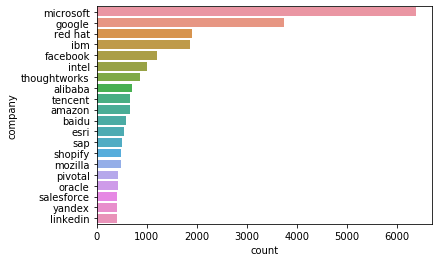

In [23]:
top20=namesWithMapping.loc[0:20]
import seaborn as sns
ax=sns.barplot(x='count',y='company',data=top20)

Additionally, we can create a barplot depiciting the counts for the various affiliations we have mapped

<Figure size 3200x6400 with 0 Axes>

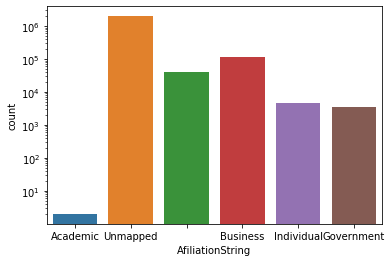

<Figure size 3200x6400 with 0 Axes>

In [35]:

import matplotlib.pyplot as plt

#establish new column
fixedDataframe['AfiliationString']=''

#set an appropriate string 
fixedDataframe['AfiliationString'].loc[fixedDataframe['is_business']]='Business'
fixedDataframe['AfiliationString'].loc[fixedDataframe['is_gov']]='Government'
fixedDataframe['AfiliationString'].loc[fixedDataframe['household']]='Individual'
fixedDataframe['AfiliationString'].loc[fixedDataframe['is_academic']]='Academic'
#label unmapped by process of elimination
LabeledBoolVec=fixedDataframe[['is_gov','is_academic','household','is_business']].any(axis=1)
fixedDataframe['AfiliationString'].loc[np.logical_not(LabeledBoolVec)]='Unmapped'

#for some reason we have to go back and relabel academic?
fixedDataframe['AfiliationString'].loc[academicNanFix['is_academic']]='Academic'

#and plot
ax=sns.countplot(x='AfiliationString',data=fixedDataframe)
ax.set_yscale("log")
plt.figure(figsize=(16,32),dpi=200)                                   

In [36]:
print(np.where(academicNanFix['is_academic']))

(array([     10,     163,     198, ..., 2143274, 2143347, 2143377]),)


In [33]:
sectorCounts=fixedDataframe['AfiliationString'].value_counts()
sectorCounts.head(6)

Unmapped      1981323
Business       114421
                39552
Individual       4715
Government       3573
Name: AfiliationString, dtype: int64